In [1]:
%%capture
!pip install transformers

In [2]:
import pandas as pd
import torch
import numpy as np
from transformers import BertTokenizer, BertModel
from torch import nn
from torch.optim import Adam
from tqdm import tqdm

/home/tfsservices/miniconda3/envs/nlp_test/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
datapath = f'bbc-text.csv'
df = pd.read_csv(datapath)
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


<Axes: xlabel='Category'>

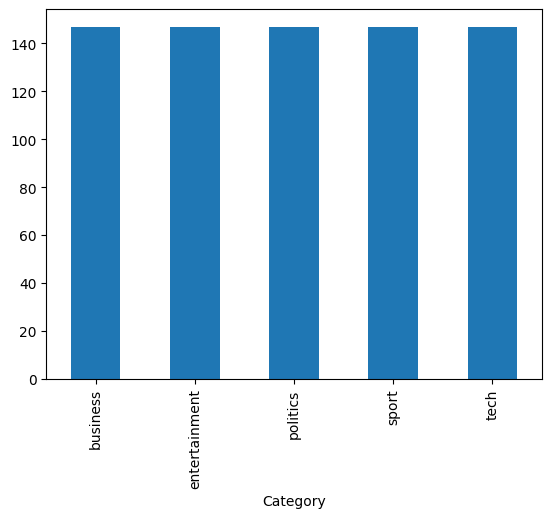

In [6]:
df.groupby(['category']).size().plot.bar()

In [19]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
labels = {
    'business':0,
    'entertainment':1,
    'sport':2,
    'tech':3,
    'politics':4
}


ids_to_labels = {v: k for v, k in enumerate(labels)}


{0: 'business', 1: 'entertainment', 2: 'sport', 3: 'tech', 4: 'politics'}


In [ ]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['category']]
        self.texts = [
            tokenizer(text, 
                      padding='max_length', max_length = 512, truncation=True,
                      return_tensors="pt") for text in df['text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [5]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 5)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [6]:
def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} | Train Accuracy: {total_acc_train / len(train_data): .3f} | Val Loss: {total_loss_val / len(val_data): .3f} | Val Accuracy: {total_acc_val / len(val_data): .3f}')


In [7]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

            test_label = test_label.to(device)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)

            acc = (output.argmax(dim=1) == test_label).sum().item()
            total_acc_test += acc
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')

In [8]:
np.random.seed(112)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42), 
                                     [int(.8*len(df)), int(.9*len(df))])

print(len(df_train),len(df_val), len(df_test))

1780 222 223


In [9]:
EPOCHS = 5
model = BertClassifier()
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 890/890 [00:51<00:00, 17.36it/s]


Epochs: 1 | Train Loss:  0.733 | Train Accuracy:  0.390 | Val Loss:  0.629 | Val Accuracy:  0.568


100%|██████████| 890/890 [00:50<00:00, 17.54it/s]


Epochs: 2 | Train Loss:  0.421 | Train Accuracy:  0.816 | Val Loss:  0.250 | Val Accuracy:  0.982


100%|██████████| 890/890 [00:50<00:00, 17.60it/s]


Epochs: 3 | Train Loss:  0.188 | Train Accuracy:  0.967 | Val Loss:  0.121 | Val Accuracy:  0.982


100%|██████████| 890/890 [00:50<00:00, 17.59it/s]


Epochs: 4 | Train Loss:  0.098 | Train Accuracy:  0.983 | Val Loss:  0.079 | Val Accuracy:  0.982


100%|██████████| 890/890 [00:50<00:00, 17.59it/s]


Epochs: 5 | Train Loss:  0.056 | Train Accuracy:  0.992 | Val Loss:  0.062 | Val Accuracy:  0.986


In [10]:
evaluate(model, df_test)

Test Accuracy:  0.987


In [34]:
def evaluate_one_text(model, sentence):

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:
        model = model.cuda()

    text = tokenizer(sentence, padding='max_length', max_length = 512, truncation=True, return_tensors="pt")

    mask = text['attention_mask'].to(device)
    input_id = text['input_ids'].to(device)
    # label_ids = torch.Tensor(align_word_ids(sentence)).unsqueeze(0).to(device)

    output = model(input_id, mask)

    label_id = output.argmax(dim=1)[0].item()

    label = ids_to_labels[label_id]
    # print(sentence)
    print(label)

In [42]:
evaluate_one_text(model, "This dangerous period will be crystalized this weekend when Western foreign policy officials and experts gather for the annual Munich Security Conference, which is set to be dominated by the deepening war in Ukraine. But the event will also become a stage for the rivalry between the United States and China with both Secretary of State Antony Blinken and Chinese top diplomat Wang Yi in town. The State Department says no meetings are planned as details emerge about China's global balloon spying program and accusations fly back and forth across the Pacific.The double diplomatic crisis has also exposed the way that Washington's bitterly polarized politics could influence US policy overseas and the political capital every administration needs to pursue its aims. Fervent Republican criticism of Biden's failure to shoot down a Chinese surveillance balloon before it traversed the continent followed by claims that he's trigger happy in downing subsequent unknown aerial objects, show that for many in the GOP -- critical geopolitics are just another excuse for partisan score settling. Biden may have played into this by not speaking publicly to Americans about a trio of incidents in which jets were scrambled over the weekend. But more broadly, the Republican Party's abdication of the internationalist principles that won the Cold War against the Soviet Union, its splits over funding for Ukraine and the possibility of another White House term for Donald Trump who turned US foreign policy into a mirror of his own volatile temperament raise even more questions as the 2024 election looms.")

politics
